# Import libraries

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from dirrac.classifier.logistic import logistic_classifier, logistic_visualize
from dirrac.data.synthetic_data import DataSynthesizer
from dirrac.gen_counterfactual import DRRA
from ar.gen_counterfactual import LinearAR
from wachter.gen_counterfactual import Wachter
from roar.gen_counterfactual import ROAR
from mace.loadModel import loadModelForDataset
from utils import pad_ones, cal_validity

In [3]:
if not os.path.exists('result/figure4/'):
    os.makedirs('result/figure4/')

# Synthesize data and train original classifier

In [4]:
# Synthesize data 
mean_0 = np.ones(2) * (-3)
mean_1 = np.ones(2) * 3
cov_0 = cov_1 = np.identity(2)
n = 1000
p = [0.3, 0.4, 0.3]

sd = DataSynthesizer(mean_0, cov_0, mean_1, cov_1, n)
features, labels = sd.synthesize_modes_data(100, [0.3, 0.4, 0.3], [0.1, 0.1])

In [5]:
# Train 101 logistic classifiers - the first classifier is on original data, other
all_coef = np.zeros((101, 3))
for i in range(101):
    coef = logistic_classifier(pad_ones(features[i]), labels[i])[1].T
    all_coef[i] = np.squeeze(coef)

# Get theta
mean_shift = all_coef[1:31]
cov_shift = all_coef[31:71]
both_shift = all_coef[71:101]

theta = np.zeros((3, 3))
sigma = np.zeros((3, 3, 3))

theta[0], sigma[0] = np.mean(mean_shift, axis=0), np.cov(mean_shift.T)
theta[1], sigma[1] = np.mean(cov_shift, axis=0), np.cov(cov_shift.T)
theta[2], sigma[2] = np.mean(both_shift, axis=0), np.cov(both_shift.T)

# Save to csv

In [6]:
df = pd.DataFrame(columns=['label', 'x0', 'x1'])
df['label'] = labels[0]
df['x0'] = features[0][:, 0]
df['x1'] = features[0][:, 1]
df.to_csv('mace/_data_main/processed_data/synthetic_data.csv', index=False)

In [7]:
df

,label,x0,x1
0,0.0,-3.006827,-1.953857
1,0.0,-2.258412,-2.276043
2,0.0,-1.381224,-4.205558
3,0.0,-3.626955,-4.320663
4,0.0,-3.107753,-2.001236
...,...,...,...
995,1.0,3.234664,4.055022
996,1.0,2.128208,2.987203
997,1.0,3.045903,1.575229
998,1.0,4.178026,4.701101


In [8]:
# Train the original classifier and get the instances that are classified as negative class
model_trained, X_train, y_train, X_test, y_test = loadModelForDataset('lr', 'synthetic')
X_recourse = X_test[model_trained.predict(X_test) == 0]

# Initialization

In [9]:
# DDRA 
delta = 0.1
k = 3
dim = 3
rho = np.array([0, 0, 0])
lmbda = 0.7
zeta = 1

drra_module = DRRA(delta, k, dim, p, theta, sigma, rho, lmbda, zeta, dist_type='l1', padding=True)
ar_module = LinearAR(X_train, model_trained.coef_, model_trained.intercept_)
wachter_module = Wachter(X_train, model_trained, decision_threshold=0.5, linear=True)
roar_module = ROAR(X_train, model_trained.coef_.squeeze(), model_trained.intercept_, max_iter=30)

# Generate counterfactual

In [10]:
print("Generate counterfactual for DiRRAc")
counterfactual_drra_nm = drra_module.fit_data(pad_ones(X_recourse), model='nm')
print("Generate counterfactual for Gaussian DiRRAc")
counterfactual_drra_gm = drra_module.fit_data(pad_ones(X_recourse), model='gm')
print("Generate counterfactual for AR")
counterfactual_ar = ar_module.fit_data(X_recourse)
print("Generate counterfactual for Wachter")
counterfactual_wachter = wachter_module.fit_data(X_recourse)
print("Generate counterfactual for ROAR")
counterfactual_roar = roar_module.fit_data(X_recourse)

Generate counterfactual for DiRRAc


100%|█████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.48it/s]


Generate counterfactual for Gaussian DiRRAc


100%|█████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.71it/s]


Generate counterfactual for AR


100%|█████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 68.32it/s]


Generate counterfactual for Wachter


100%|█████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.17it/s]


Generate counterfactual for ROAR


100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 138.81it/s]


In [11]:
# Define shift params
alpha_l = [0.2 * i for i in range(11)]
beta_l = [0.2 * i for i in range(11)]

def run_experiments(shift_type='mean'):
    """ Run experiments for 3 types of data distribution shifts """
    # Init
    validity_drra_nm, std_drra_nm = np.zeros(len(alpha_l)), np.zeros(len(alpha_l))
    validity_drra_gm, std_drra_gm = np.zeros(len(alpha_l)), np.zeros(len(alpha_l))
    validity_ar, std_ar = np.zeros(len(alpha_l)), np.zeros(len(alpha_l))
    validity_wachter, std_wachter = np.zeros(len(alpha_l)), np.zeros(len(alpha_l))
    validity_roar, std_roar = np.zeros(len(alpha_l)), np.zeros(len(alpha_l))

    for i in range(1, len(alpha_l)):      
        
        mean_shift = mean_0 + [alpha_l[i], 0] if shift_type in ['mean', 'both'] else mean_0
        cov_shift = cov_0 * (1 + beta_l[i]) if shift_type in ['cov', 'both'] else cov_0
        
        iter_drra_nm = np.zeros(100)
        iter_drra_gm = np.zeros(100)
        iter_ar = np.zeros(100)
        iter_wachter = np.zeros(100)
        iter_roar = np.zeros(100)

        features, labels = sd.synthesize_data(mean_shift, cov_shift, mean_1, cov_1)
        for j in range(100):
            features, labels = sd.synthesize_data(mean_shift, cov_shift, mean_1, cov_1)
            clf_shift, coef_shift = logistic_classifier(features, labels)

            iter_drra_nm[j] = cal_validity(clf_shift.predict(counterfactual_drra_nm[:, :-1]))
            iter_drra_gm[j] = cal_validity(clf_shift.predict(counterfactual_drra_gm[:, :-1]))
            iter_ar[j] = cal_validity(clf_shift.predict(counterfactual_ar))
            iter_wachter[j] = cal_validity(clf_shift.predict(counterfactual_wachter))
            iter_roar[j] = cal_validity(clf_shift.predict(counterfactual_roar))
        
        validity_drra_nm[i], std_drra_nm[i] = np.mean(iter_drra_nm), np.std(iter_drra_nm)
        validity_drra_gm[i], std_drra_gm[i] = np.mean(iter_drra_gm), np.std(iter_drra_gm)
        validity_ar[i], std_ar[i] = np.mean(iter_ar), np.std(iter_ar)
        validity_wachter[i], std_wachter[i] = np.mean(iter_wachter), np.std(iter_wachter)
        validity_roar[i], std_roar[i] = np.mean(iter_roar), np.std(iter_roar)

    # Validity for original data
    validity_drra_nm[0] = cal_validity(model_trained.predict(counterfactual_drra_nm[:, :-1]))
    validity_drra_gm[0] = cal_validity(model_trained.predict(counterfactual_drra_gm[:, :-1]))
    validity_ar[0] = cal_validity(model_trained.predict(counterfactual_ar))
    validity_wachter[0] = cal_validity(model_trained.predict(counterfactual_wachter))
    validity_roar[0] = cal_validity(model_trained.predict(counterfactual_roar))

    return validity_drra_nm, validity_drra_gm, validity_ar, validity_wachter, validity_roar, std_drra_nm, std_drra_gm, std_ar, std_wachter, std_roar

# Data distribution shift plot

In [12]:
# Matplotlib config
SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE - 2)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize

# Mean shift

In [13]:
validity_drra_nm_mean, validity_drra_gm_mean, validity_ar_mean, validity_wachter_mean, validity_roar_mean, std_drra_nm_mean, std_drra_gm_mean, std_ar_mean, std_wachter_mean, std_roar_mean = run_experiments(shift_type='mean')

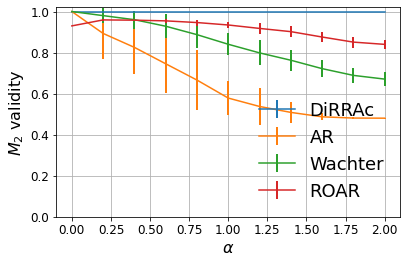

In [14]:
# Plot
fig, ax = plt.subplots()

ax.errorbar(alpha_l, validity_drra_nm_mean, std_drra_nm_mean, label='DiRRAc', elinewidth=2.0)
ax.errorbar(alpha_l, validity_ar_mean, std_ar_mean, label='AR', elinewidth=2.0)
ax.errorbar(alpha_l, validity_wachter_mean, std_wachter_mean, label='Wachter', elinewidth=2.0)
ax.errorbar(alpha_l, validity_roar_mean, std_roar_mean, label='ROAR', elinewidth=2.0)

ax.set(xlabel='$\\alpha$', ylabel='$M_{2}$ validity')
ax.grid()
ax.legend(loc='lower right', frameon=False)
plt.ylim(0, 1.02)
plt.savefig('result/figure4/mean_shift_DiRAAc-NM.pdf', dpi=400)
plt.tight_layout()

plt.show()# Define shift params

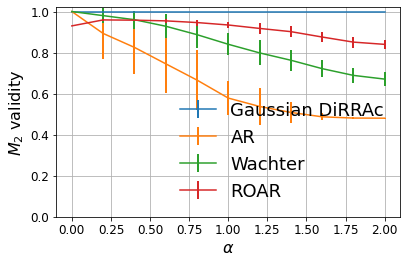

In [15]:
# Plot
fig, ax = plt.subplots()

ax.errorbar(alpha_l, validity_drra_gm_mean, std_drra_gm_mean, label='Gaussian DiRRAc', elinewidth=2.0)
ax.errorbar(alpha_l, validity_ar_mean, std_ar_mean, label='AR', elinewidth=2.0)
ax.errorbar(alpha_l, validity_wachter_mean, std_wachter_mean, label='Wachter', elinewidth=2.0)
ax.errorbar(alpha_l, validity_roar_mean, std_roar_mean, label='ROAR', elinewidth=2.0)

ax.set(xlabel='$\\alpha$', ylabel='$M_{2}$ validity')
ax.grid()
ax.legend(loc='lower right', frameon=False)
plt.ylim(0, 1.02)
plt.savefig('result/figure4/mean_shift_DiRAAc-GM.pdf', dpi=400)
plt.tight_layout()

plt.show()

# Covariance shift

In [16]:
validity_drra_nm_cov, validity_drra_gm_cov, validity_ar_cov, validity_wachter_cov, validity_roar_cov, std_drra_nm_cov, std_drra_gm_cov, std_ar_cov, std_wachter_cov, std_roar_cov = run_experiments(shift_type='cov')

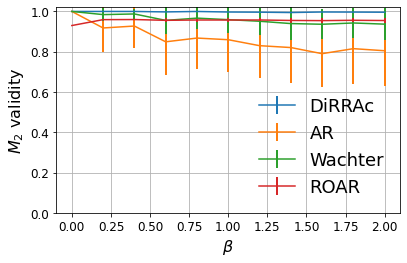

In [17]:
# Plot
fig, ax = plt.subplots()

ax.errorbar(alpha_l, validity_drra_nm_cov, std_drra_nm_cov, label='DiRRAc', elinewidth=2.0)
ax.errorbar(alpha_l, validity_ar_cov, std_ar_cov, label='AR', elinewidth=2.0)
ax.errorbar(alpha_l, validity_wachter_cov, std_wachter_cov, label='Wachter', elinewidth=2.0)
ax.errorbar(alpha_l, validity_roar_cov, std_roar_cov, label='ROAR', elinewidth=2.0)

ax.set(xlabel='$\\beta$', ylabel='$M_{2}$ validity')
ax.grid()
ax.legend(loc='lower right', frameon=False)
plt.ylim(0, 1.02)
plt.savefig('result/figure4/covariance_shift_DiRAAc-NM.pdf', dpi=400)
plt.tight_layout()

plt.show()

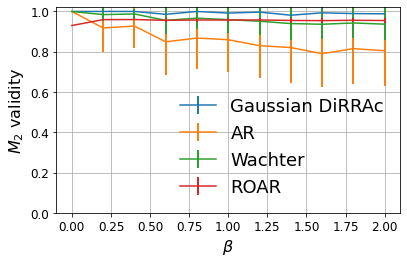

In [18]:
# Plot
fig, ax = plt.subplots()

ax.errorbar(alpha_l, validity_drra_gm_cov, std_drra_gm_cov, label='Gaussian DiRRAc', elinewidth=2.0)
ax.errorbar(alpha_l, validity_ar_cov, std_ar_cov, label='AR', elinewidth=2.0)
ax.errorbar(alpha_l, validity_wachter_cov, std_wachter_cov, label='Wachter', elinewidth=2.0)
ax.errorbar(alpha_l, validity_roar_cov, std_roar_cov, label='ROAR', elinewidth=2.0)

ax.set(xlabel='$\\beta$', ylabel='$M_{2}$ validity')
ax.grid()
ax.legend(loc='lower right', frameon=False)
plt.ylim(0, 1.02)
plt.savefig('result/figure4/covariance_shift_DiRAAc-GM.pdf', dpi=400)
plt.tight_layout()

plt.show()

# Mean and Covariance shift

In [19]:
validity_drra_nm_both, validity_drra_gm_both, validity_ar_both, validity_wachter_both, validity_roar_both, std_drra_nm_both, std_drra_gm_both, std_ar_both, std_wachter_both, std_roar_both = run_experiments(shift_type='both')

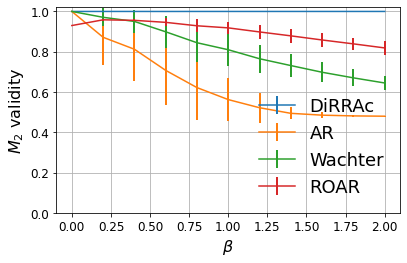

In [20]:
# Plot
ax = plt.gca()

ax.errorbar(alpha_l, validity_drra_nm_both, std_drra_nm_both, label='DiRRAc', elinewidth=2.0)
ax.errorbar(alpha_l, validity_ar_both, std_ar_both, label='AR', elinewidth=2.0)
ax.errorbar(alpha_l, validity_wachter_both, std_wachter_both, label='Wachter', elinewidth=2.0)
ax.errorbar(alpha_l, validity_roar_both, std_roar_both, label='ROAR', elinewidth=2.0)

ax.set(xlabel='$\\beta$', ylabel='$M_{2}$ validity')
ax.grid()
ax.legend(loc='lower right', frameon=False)
plt.ylim(0, 1.02)
plt.savefig('result/figure4/both_shift_DiRAAc-NM.pdf', dpi=400)
plt.tight_layout()

plt.show()

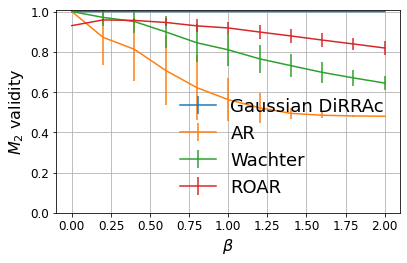

In [21]:
# Plot
ax = plt.gca()

ax.errorbar(alpha_l, validity_drra_gm_both, std_drra_gm_both, label='Gaussian DiRRAc')
ax.errorbar(alpha_l, validity_ar_both, std_ar_both, label='AR')
ax.errorbar(alpha_l, validity_wachter_both, std_wachter_both, label='Wachter')
ax.errorbar(alpha_l, validity_roar_both, std_roar_both, label='ROAR')

ax.set(xlabel='$\\beta$', ylabel='$M_{2}$ validity')
ax.grid()
ax.legend(loc='lower right', frameon=False)
plt.ylim(0, 1.01)
# ax.set_aspect('equal')
plt.savefig('result/figure4/both_shift_DiRAAc-GM.pdf', dpi=400)
plt.tight_layout()

plt.show()

# Plot multiple figure

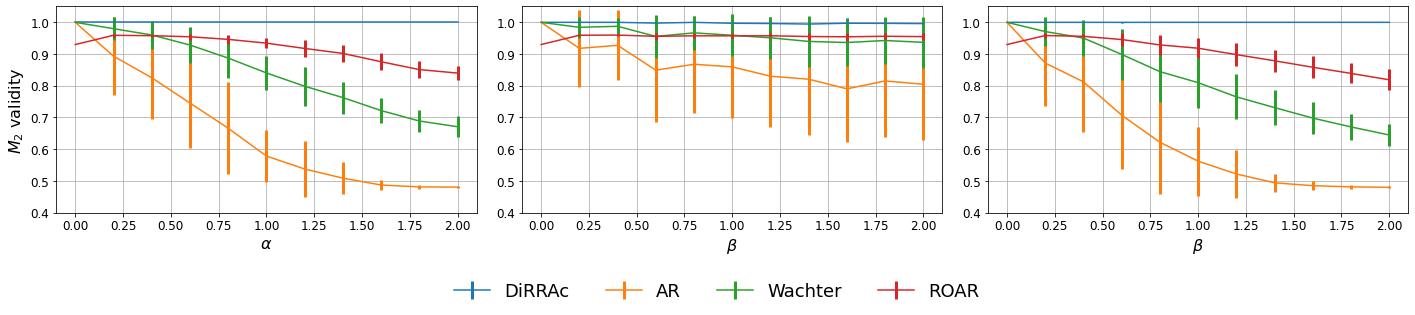

In [24]:
# Plot
fig, ax = plt.subplots(1, 3, figsize=(20, 4))

ax[0].errorbar(alpha_l, validity_drra_nm_mean, std_drra_gm_mean, label='DiRRAc', elinewidth=3.0)
ax[0].errorbar(alpha_l, validity_ar_mean, std_ar_mean, label='AR', elinewidth=3.0)
ax[0].errorbar(alpha_l, validity_wachter_mean, std_wachter_mean, label='Wachter', elinewidth=3.0)
ax[0].errorbar(alpha_l, validity_roar_mean, std_roar_mean, label='ROAR', elinewidth=3.0)
ax[0].set(xlabel='$\\alpha$')
ax[0].set_ylim(0.4, 1.05)
ax[0].grid()

ax[1].errorbar(alpha_l, validity_drra_nm_cov, std_drra_nm_cov, label='DiRRAc', elinewidth=3.0)
ax[1].errorbar(alpha_l, validity_ar_cov, std_ar_cov, label='AR', elinewidth=3.0)
ax[1].errorbar(alpha_l, validity_wachter_cov, std_wachter_cov, label='Wachter', elinewidth=3.0)
ax[1].errorbar(alpha_l, validity_roar_cov, std_roar_cov, label='ROAR', elinewidth=3.0)
ax[1].set(xlabel='$\\beta$')
ax[1].set_ylim(0.4, 1.05)
ax[1].grid()


ax[2].errorbar(alpha_l, validity_drra_nm_both, std_drra_nm_both, label='DiRRAc', elinewidth=3.0)
ax[2].errorbar(alpha_l, validity_ar_both, std_ar_both, label='AR', elinewidth=3.0)
ax[2].errorbar(alpha_l, validity_wachter_both, std_wachter_both, label='Wachter', elinewidth=3.0)
ax[2].errorbar(alpha_l, validity_roar_both, std_roar_both, label='ROAR', elinewidth=3.0)
ax[2].set(xlabel='$\\beta$')
ax[2].set_ylim(0.4, 1.05)
ax[2].grid()

lines, labels = fig.axes[-1].get_legend_handles_labels()
lgd = fig.legend(lines, labels, bbox_to_anchor=(0.7, 0.03), ncol = 4, frameon=False)
plt.setp(ax[0], ylabel='$M_{2}$ validity')

plt.savefig('result/figure4/DiRAAc_combine.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=400)
plt.tight_layout()

plt.show()

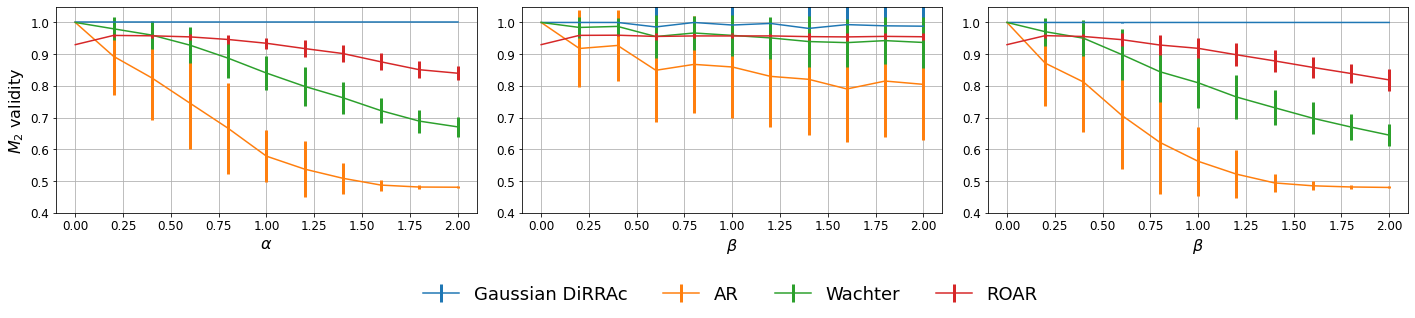

In [26]:
# Plot
fig, ax = plt.subplots(1, 3, figsize=(20, 4))

ax[0].errorbar(alpha_l, validity_drra_gm_mean, std_drra_gm_mean, label='Gaussian DiRRAc', elinewidth=3.0)
ax[0].errorbar(alpha_l, validity_ar_mean, std_ar_mean, label='AR', elinewidth=3.0)
ax[0].errorbar(alpha_l, validity_wachter_mean, std_wachter_mean, label='Wachter', elinewidth=3.0)
ax[0].errorbar(alpha_l, validity_roar_mean, std_roar_mean, label='ROAR', elinewidth=3.0)
ax[0].set(xlabel='$\\alpha$')
ax[0].set_ylim(0.4, 1.05)
ax[0].grid()

ax[1].errorbar(alpha_l, validity_drra_gm_cov, std_drra_gm_cov, label='Gaussian DiRRAc', elinewidth=3.0)
ax[1].errorbar(alpha_l, validity_ar_cov, std_ar_cov, label='AR', elinewidth=3.0)
ax[1].errorbar(alpha_l, validity_wachter_cov, std_wachter_cov, label='Wachter', elinewidth=3.0)
ax[1].errorbar(alpha_l, validity_roar_cov, std_roar_cov, label='ROAR', elinewidth=3.0)
ax[1].set(xlabel='$\\beta$')
ax[1].set_ylim(0.4, 1.05)
ax[1].grid()


ax[2].errorbar(alpha_l, validity_drra_gm_both, std_drra_gm_both, label='Gaussian DiRRAc', elinewidth=3.0)
ax[2].errorbar(alpha_l, validity_ar_both, std_ar_both, label='AR', elinewidth=3.0)
ax[2].errorbar(alpha_l, validity_wachter_both, std_wachter_both, label='Wachter', elinewidth=3.0)
ax[2].errorbar(alpha_l, validity_roar_both, std_roar_both, label='ROAR', elinewidth=3.0)
ax[2].set(xlabel='$\\beta$')
ax[2].set_ylim(0.4, 1.05)
ax[2].grid()

lines, labels = fig.axes[-1].get_legend_handles_labels()
lgd = fig.legend(lines, labels, bbox_to_anchor=(0.74, 0.02), ncol = 4, frameon=False)

plt.setp(ax[0], ylabel='$M_{2}$ validity')
    
plt.savefig('result/figure4/Gaussian_DiRAAc_combine.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=400)
plt.tight_layout()

plt.show()